# Predict Helpfulness of Game Reviews

In this notebook, I replicated the study by Müller et al. (2016) for predicting the helpfulness of online customer reviews using the video games dataset. The following parts are implemented in this Jupyter Notebook:

- Data import and exploration 
- Data preprocessing 
- Text preprocessing
- LDA topics generation and features engineering using documents probabilities for generated topics
- RandomForest classifier model training, evaluation and prediction (on test dataset)
- Metrics plotting

#### Created on Sat Feb 11 16:53:11 2023

#### @author: Vaishob Anand

In [1]:
# Libraries imported 
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np 
import gzip
import ast

import nltk
from nltk.corpus import stopwords
import gensim
from gensim.utils import simple_preprocess
import spacy
from spacy.tokens import Doc
import gensim.corpora as corpora
from gensim.models import LdaModel

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import joblib
from sklearn import metrics

In [2]:
# Static values/variables
LDA_TOPICS_N = 100
LDA_PASSES_N = 1 # 10
LDA_ALPHA = 'auto'
LDA_MIN_PROB = 0
LDA_CHUNK = 10000
DF_ROWS_N = None # 10000

#### Importing data

Below we import the Pandas data frame - taken from the source data page: https://jmcauley.ucsd.edu/data/amazon/

The `reviews_Video_Games.json.gz` dataset is used. This is a dense subset for Video Games reviews (5-core: 231,780 reviews), where **each of the remaining users and items have k reviews each**

Dataset link: https://snap.stanford.edu/data/amazon/productGraph/categoryFiles/reviews_Video_Games_5.json.gz

Dataset description:
- reviewerID - ID of the reviewer
- asin - ID of the product
- reviewerName - name of the reviewer
- helpful - helpfulness rating of the review
- reviewText - text of the review
- overall - rating of the product 
- summary - summary of the review
- unixReviewTime - time of the review (unix time)
- reviewTime - time of the review (raw)

In [3]:
def parse(path):
    g = gzip.open(path, 'rb')
    for i in g:
        yield eval(i)

def getDF(path):
    i = 0
    df = {}
    for d in parse(path):
        df[i] = d
        i += 1
    return pd.DataFrame.from_dict(df, orient='index')

df = getDF('reviews_Video_Games.json.gz')

#### Exploratory Data Analysis (EDA)

In [4]:
# View data 
df.head(5)

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,AB9S9279OZ3QO,0078764343,Alan,"[1, 1]",I haven't gotten around to playing the campaig...,5.0,Good game and Beta access!!,1373155200,"07 7, 2013"
1,A24SSUT5CSW8BH,0078764343,Kindle Customer,"[0, 0]",I want to start off by saying I have never pla...,5.0,Love the game,1377302400,"08 24, 2013"
2,AK3V0HEBJMQ7J,0078764343,"Miss Kris ""Krissy""","[0, 0]",this will be my second medal of honor I love h...,4.0,MOH nice,1372896000,"07 4, 2013"
3,A10BECPH7W8HM7,043933702X,"GMC ""Old Time Modeler""","[0, 0]","great game when it first came out, and still a...",5.0,Five Stars,1404950400,"07 10, 2014"
4,A2PRV9OULX1TWP,043933702X,grimi,"[0, 0]",this is the first need for speed I bought year...,5.0,memory lane,1386115200,"12 4, 2013"


In [5]:
df.columns

Index(['reviewerID', 'asin', 'reviewerName', 'helpful', 'reviewText',
       'overall', 'summary', 'unixReviewTime', 'reviewTime'],
      dtype='object')

In [6]:
len(df)

1324753

In [7]:
df['overall'].describe()

count    1.324753e+06
mean     3.978754e+00
std      1.378987e+00
min      1.000000e+00
25%      3.000000e+00
50%      5.000000e+00
75%      5.000000e+00
max      5.000000e+00
Name: overall, dtype: float64

In [8]:
df.dtypes

reviewerID         object
asin               object
reviewerName       object
helpful            object
reviewText         object
overall           float64
summary            object
unixReviewTime      int64
reviewTime         object
dtype: object

#### Data Cleaning / Preprocessing

In [9]:
# Remove records with null 'helpfulness' values ([0,0])
df_preproc = df[df['helpful'].apply(lambda x: x!=[0,0])]
print(f'New length: {len(df_preproc)}')

New length: 698157


In [10]:
# Exclude reviews with less than 2 helpfulness ratings 
df_preproc = df_preproc[df['helpful'].apply(lambda x: x[1] >= 2)]
print(f'New length: {len(df_preproc)}')

C:\Users\Vaishob\AppData\Local\Temp\ipykernel_15700\2531987885.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_preproc = df_preproc[df['helpful'].apply(lambda x: x[1] >= 2)]


New length: 493137


In [11]:
# Create column containing the ratio of helpful votes out of total votes 
df_preproc['helpful_ratio'] = df_preproc.apply(lambda row: row['helpful'][0]/row['helpful'][1], axis=1) 

Text(0.5, 1.0, 'Histogram of helpful ratio')

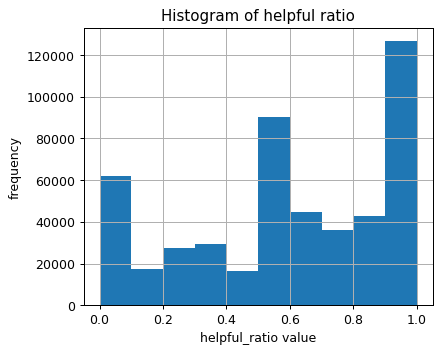

In [12]:
fig, axs = plt.subplots(dpi=90, figsize = (5, 4))
df_preproc.hist(column='helpful_ratio', ax = axs)
axs.set_xlabel('helpful_ratio value')
axs.set_ylabel('frequency')
axs.set_title('Histogram of helpful ratio')

In [13]:
# Create discretized version of above data (is_helpful)
df_preproc['is_helpful'] = df_preproc.apply(lambda row: 1 if row['helpful_ratio']>0.5 else 0, axis=1)
df_preproc.head(2)

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime,helpful_ratio,is_helpful
9,A182S3ANC0W7DL,0439342260,James,"[2, 2]",I am an Ice Cream Truck Vendor (I lease out 20...,4.0,Teach Business to Kids & Adults,1355875200,"12 19, 2012",1.000000,1
12,APDCEJMFDO2YT,0439394422,"L. Murray ""common sense""","[2, 3]","Such fast shipping, games is such great condit...",5.0,AMAZING COMPANY,1285545600,"09 27, 2010",0.666667,1


1    271706
0    221431
Name: is_helpful, dtype: int64


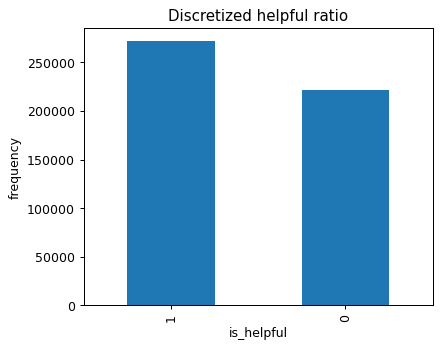

In [14]:
fig, axs = plt.subplots(dpi=90, figsize = (5, 4))
counts = df_preproc['is_helpful'].value_counts()
counts.plot(kind='bar',ax = axs)
axs.set_xlabel('is_helpful')
axs.set_ylabel('frequency')
axs.set_title('Discretized helpful ratio')
print(counts)

#### Text data preprocessing

In [15]:
# Stopwords load
nltk.download('stopwords')
stop_words = stopwords.words('english')

# Adding custom stopwords
cust_stop_words = ['game', 'play']
stop_words.extend(cust_stop_words)

# Initialize spacy doc 
nlp = spacy.load('en_core_web_sm')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Vaishob\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [16]:
# Text preprocessing function 
def text_preprocessing(doc):
    
    # Token size, Lower case, Remove special characters, Punctuation/Digits
    doc_preproc = simple_preprocess(str(doc), deacc=True)
    
    # Lemmatization
    doc_preproc_nlp = nlp(" ".join(token for token in doc_preproc))
    doc_preproc = [token.lemma_ for token in doc_preproc_nlp]
    
    # Remove extended stopwords
    doc_new = []
    [doc_new.append(token) for token in doc_preproc if token not in stop_words]
    
    return(doc_new)

In [17]:
df_txt_preproc = df_preproc.head(DF_ROWS_N)
df_txt_preproc['review'] = df_txt_preproc.apply(lambda row: text_preprocessing(row['reviewText']), axis=1)
df_txt_preproc.reset_index(inplace = True)

In [18]:
df_txt_preproc['review']

0         [ice, cream, truck, vendor, lease, truck, owne...
1         [fast, shipping, great, condition, even, inclu...
2         [son, hate, math, love, star, war, jabba, math...
3         [son, hate, math, love, like, fact, also, two,...
4         [seven, year, old, lot, fun, learn, math, time...
                                ...                        
493132                                  [good, dust, cover]
493133    [let, I, say, buy, cover, past, nothing, fit, ...
493134    [really, like, graphic, excellent, plot, great...
493135                                             [badass]
493136    [fortunate, enough, purchase, enjoy, japanese,...
Name: review, Length: 493137, dtype: object

In [19]:
# Keep original index
df_txt_preproc.rename(columns={'index':'originalIndex'}, inplace=True)

In [20]:
# Save csv file after data/text processing
df_txt_preproc.to_csv('df_txt_preproc.csv', sep = '\t', index = False)

#### Create LDA model 

In [21]:
# Load saved preprocessed dataset
df = pd.read_csv('df_txt_preproc.csv', sep ='\t')

In [22]:
# Create text_len column
df['length'] = df.apply(lambda row: len(str(row['reviewText'])), axis=1)

# Rename column 'overall' to 'stars'
df.rename(columns={'overall':'stars'}, inplace=True)

# Keep only needed columns
df = df[['originalIndex', 'is_helpful', 'length', 'stars', 'review']]

df.head(5)

,originalIndex,is_helpful,length,stars,review
0,9,1,579,4.0,"['ice', 'cream', 'truck', 'vendor', 'lease', '..."
1,12,1,374,5.0,"['fast', 'shipping', 'great', 'condition', 'ev..."
2,13,1,235,4.0,"['son', 'hate', 'math', 'love', 'star', 'war',..."
3,15,1,275,5.0,"['son', 'hate', 'math', 'love', 'like', 'fact'..."
4,16,1,245,5.0,"['seven', 'year', 'old', 'lot', 'fun', 'learn'..."


In [23]:
# Create list of processed documents 
doc_proc_list = [list(ast.literal_eval(df.review[i])) for i in range(df.shape[0])]

In [24]:
# Create dictionary
dict = corpora.Dictionary(doc_proc_list)

In [25]:
# Docs to vectors
corpus = [dict.doc2bow(doc) for doc in doc_proc_list]

In [26]:
# LDA model fit
lda = LdaModel(corpus,
    num_topics = LDA_TOPICS_N,
    id2word = dict,
    passes = LDA_PASSES_N,
    alpha = LDA_ALPHA,
    minimum_probability = LDA_MIN_PROB,
    # update_every=5,
    chunksize = LDA_CHUNK
    )

In [27]:
# Print 3 topics 
for topic in lda.show_topics(num_topics=3): print(topic) # num_words=..

(82, '0.102*"quot" + 0.091*"amp" + 0.029*"exhibit" + 0.028*"rude" + 0.026*"announcement" + 0.025*"goalie" + 0.018*"stranger" + 0.016*"unhelpful" + 0.016*"increment" + 0.015*"behavior"')
(96, '0.085*"love" + 0.050*"old" + 0.043*"kid" + 0.035*"son" + 0.034*"year" + 0.024*"great" + 0.022*"fun" + 0.022*"get" + 0.022*"buy" + 0.018*"would"')
(38, '0.031*"get" + 0.031*"work" + 0.024*"buy" + 0.020*"money" + 0.019*"try" + 0.016*"I" + 0.015*"time" + 0.014*"would" + 0.013*"one" + 0.013*"back"')


In [28]:
# Show topic sample data for first 10 topics 
df_list = []
for i in range(10):
    topic = lda.show_topic(i)
    words_list = [tuple[0] for tuple in topic]
    df_list.append(words_list)
df_topics10 = pd.DataFrame(df_list)
df_topics10.columns = [f'word {i+1}' for i in range(10)]
df_topics10['LDA topics'] = [f'Topic {i+1}' for i in range(10)]
df_topics10.set_index('LDA topics', inplace = True)
df_topics10

,word 1,word 2,word 3,word 4,word 5,word 6,word 7,word 8,word 9,word 10
LDA topics,,,,,,,,,,
Topic 1,link,zelda,island,max,legend,facebook,xcom,sword,ratchet,time
Topic 2,alien,table,pulse,freezing,downgrade,zoo,nazi,marine,ripoff,predator
Topic 3,app,crash,palm,tb,chip,mk,mortal,pe,kombat,stink
Topic 4,version,original,title,release,well,previous,much,still,new,improvement
Topic 5,madden,team,pass,franchise,football,year,nfl,de,defense,la
Topic 6,headset,comfortable,pleased,activision,head,course,hear,wear,blah,golf
Topic 7,skyrim,phone,psn,arkham,web,bluetooth,site,google,free,page
Topic 8,show,question,lego,th,answer,gamestop,ask,tv,lobby,faulty
Topic 9,origin,rpg,dragon,fan,age,rpgs,elder,like,good,system


#### Get probabilities for all documents

In [29]:
# Get probs for all documents
lda_corpus = lda[corpus]
len(lda_corpus)

493137

In [30]:
# Compile a dataframe
df_topics = pd.DataFrame(lda_corpus)
df_topics = df_topics.applymap(lambda x: x[1])

col_names = []
for i in range(len(df_topics.columns)):
    col_names.append(f'Topic {i+1}')

df_topics.columns = col_names
df_topics

,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9,Topic 10,...,Topic 91,Topic 92,Topic 93,Topic 94,Topic 95,Topic 96,Topic 97,Topic 98,Topic 99,Topic 100
0,0.000231,0.000230,0.000229,0.000415,0.000250,0.000260,0.000308,0.102163,0.000251,0.000265,...,0.000261,0.000221,0.000264,0.000254,0.000347,0.000298,0.029189,0.000241,0.000289,0.000469
1,0.000315,0.000313,0.000312,0.000567,0.000342,0.000354,0.000420,0.000440,0.000342,0.000361,...,0.000356,0.000301,0.000360,0.000346,0.000473,0.000406,0.094272,0.000328,0.000394,0.000640
2,0.000423,0.000421,0.000419,0.000761,0.000459,0.000476,0.000564,0.000590,0.000459,0.000485,...,0.000478,0.000404,0.000483,0.000464,0.000635,0.000545,0.250084,0.000440,0.000528,0.064641
3,0.000520,0.000516,0.000515,0.000934,0.000563,0.000584,0.000693,0.000724,0.000564,0.000595,...,0.000587,0.000496,0.000593,0.000570,0.000780,0.000670,0.127565,0.000541,0.000649,0.001054
4,0.000676,0.000672,0.000670,0.001216,0.000733,0.000760,0.000902,0.000943,0.000734,0.000775,...,0.000764,0.000646,0.000772,0.000742,0.001015,0.000872,0.579078,0.000704,0.000845,0.001373
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
493132,0.002441,0.002426,0.002417,0.004389,0.002646,0.002744,0.003255,0.003403,0.002649,0.002795,...,0.002757,0.002330,0.002784,0.002679,0.003664,0.003146,0.007567,0.002541,0.003048,0.004953
493133,0.000769,0.000764,0.000761,0.001382,0.000833,0.000864,0.001025,0.001072,0.000834,0.000880,...,0.000868,0.000734,0.000877,0.000844,0.001154,0.000991,0.002383,0.000800,0.000960,0.001560
493134,0.000676,0.000672,0.000670,0.001216,0.000733,0.000760,0.000902,0.000943,0.000734,0.000774,...,0.000764,0.000645,0.000771,0.000742,0.001015,0.000871,0.002096,0.000704,0.000844,0.001372
493135,0.004321,0.004294,0.004279,0.007769,0.004684,0.004857,0.005762,0.006024,0.004688,0.004947,...,0.004880,0.004124,0.004928,0.004742,0.006485,0.005569,0.013395,0.004497,0.005395,0.008767


In [31]:
# Concatenate dataframes 
df_label_features = pd.concat([df,df_topics], axis=1).drop('review', axis = 1)
df_label_features 

,originalIndex,is_helpful,length,stars,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,...,Topic 91,Topic 92,Topic 93,Topic 94,Topic 95,Topic 96,Topic 97,Topic 98,Topic 99,Topic 100
0,9,1,579,4.0,0.000231,0.000230,0.000229,0.000415,0.000250,0.000260,...,0.000261,0.000221,0.000264,0.000254,0.000347,0.000298,0.029189,0.000241,0.000289,0.000469
1,12,1,374,5.0,0.000315,0.000313,0.000312,0.000567,0.000342,0.000354,...,0.000356,0.000301,0.000360,0.000346,0.000473,0.000406,0.094272,0.000328,0.000394,0.000640
2,13,1,235,4.0,0.000423,0.000421,0.000419,0.000761,0.000459,0.000476,...,0.000478,0.000404,0.000483,0.000464,0.000635,0.000545,0.250084,0.000440,0.000528,0.064641
3,15,1,275,5.0,0.000520,0.000516,0.000515,0.000934,0.000563,0.000584,...,0.000587,0.000496,0.000593,0.000570,0.000780,0.000670,0.127565,0.000541,0.000649,0.001054
4,16,1,245,5.0,0.000676,0.000672,0.000670,0.001216,0.000733,0.000760,...,0.000764,0.000646,0.000772,0.000742,0.001015,0.000872,0.579078,0.000704,0.000845,0.001373
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
493132,1324722,1,20,5.0,0.002441,0.002426,0.002417,0.004389,0.002646,0.002744,...,0.002757,0.002330,0.002784,0.002679,0.003664,0.003146,0.007567,0.002541,0.003048,0.004953
493133,1324723,1,108,5.0,0.000769,0.000764,0.000761,0.001382,0.000833,0.000864,...,0.000868,0.000734,0.000877,0.000844,0.001154,0.000991,0.002383,0.000800,0.000960,0.001560
493134,1324724,1,180,4.0,0.000676,0.000672,0.000670,0.001216,0.000733,0.000760,...,0.000764,0.000645,0.000771,0.000742,0.001015,0.000871,0.002096,0.000704,0.000844,0.001372
493135,1324741,1,11,5.0,0.004321,0.004294,0.004279,0.007769,0.004684,0.004857,...,0.004880,0.004124,0.004928,0.004742,0.006485,0.005569,0.013395,0.004497,0.005395,0.008767


In [32]:
# Store final dataset with all engineered features as a CSV file 
df_label_features.to_csv('df_label_features.csv', sep = '\t', index = False)

In [33]:
# Save dictionary 
dict.save('dictionary.dict')

In [34]:
# Save corpus 
gensim.corpora.MmCorpus.serialize('corpus.mm', corpus)

In [35]:
# Save lda model 
lda.save('lda_model.mdl')

In [36]:
# Save topics 
with open('lda_topics.data', 'w') as file:
    topics_data=lda.print_topics(num_topics=LDA_TOPICS_N)
    file.write(str(topics_data))

In [37]:
# Test load LDA model 
lda1 = gensim.models.ldamodel.LdaModel.load('lda_model.mdl')
print(lda1)

LdaModel(num_terms=260495, num_topics=100, decay=0.5, chunksize=10000)


#### Test model 

In [38]:
# Test LDA topics probability for custom tokens
query = dict.doc2bow(['like', 'toy', 'joy'])
print(query)
lda_query = lda[query]
print(lda_query)

[(64, 1), (92, 1), (452, 1)]
[(0, 0.002441378), (1, 0.0024264378), (2, 0.0024178457), (3, 0.0043899175), (4, 0.0026465864), (5, 0.0027446593), (6, 0.0032558804), (7, 0.0034039125), (8, 0.0026493147), (9, 0.002795556), (10, 0.0025042912), (11, 0.0041933293), (12, 0.002614871), (13, 0.0031979803), (14, 0.002565319), (15, 0.006754919), (16, 0.002850765), (17, 0.0027254059), (18, 0.0034193501), (19, 0.0054982374), (20, 0.0025519102), (21, 0.0057388633), (22, 0.002620565), (23, 0.00536505), (24, 0.0031843556), (25, 0.002625392), (26, 0.0032753057), (27, 0.002633595), (28, 0.0050387764), (29, 0.54850537), (30, 0.0037637267), (31, 0.0027703338), (32, 0.0029427425), (33, 0.0044404357), (34, 0.0036944202), (35, 0.006396281), (36, 0.002854768), (37, 0.0023291986), (38, 0.0086643165), (39, 0.002450739), (40, 0.004621957), (41, 0.004231792), (42, 0.0032424065), (43, 0.0027474968), (44, 0.0037360932), (45, 0.002871325), (46, 0.0051003867), (47, 0.005767047), (48, 0.0038247895), (49, 0.0021828515), 

#### Build RandomForest classifier

In [39]:
# Load saved dataset with features and label 
df = pd.read_csv('df_label_features.csv', sep='\t')

In [40]:
df.head(3)

,originalIndex,is_helpful,length,stars,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,...,Topic 91,Topic 92,Topic 93,Topic 94,Topic 95,Topic 96,Topic 97,Topic 98,Topic 99,Topic 100
0,9,1,579,4.0,0.000231,0.000230,0.000229,0.000415,0.000250,0.000260,...,0.000261,0.000221,0.000264,0.000254,0.000347,0.000298,0.029189,0.000241,0.000289,0.000469
1,12,1,374,5.0,0.000315,0.000313,0.000312,0.000567,0.000342,0.000354,...,0.000356,0.000301,0.000360,0.000346,0.000473,0.000406,0.094272,0.000328,0.000394,0.000640
2,13,1,235,4.0,0.000423,0.000421,0.000419,0.000761,0.000459,0.000476,...,0.000478,0.000404,0.000483,0.000464,0.000635,0.000545,0.250084,0.000440,0.000528,0.064641


In [41]:
# Train test data split

# All features
X=df.drop(['is_helpful', 'originalIndex'], axis = 1)

# Labels 
y=df['is_helpful']

# Stratified split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.20, random_state=10)

In [42]:
# Create and fit RF
rf = RandomForestClassifier(n_estimators = 120, n_jobs = -1, random_state = 10)
rf_model = rf.fit(X_train, y_train)

In [43]:
# Evaluate rf_model
accuracy = rf_model.score(X_test, y_test)

In [44]:
# Print feature importances 
feature_importances = pd.Series(rf_model.feature_importances_, index=X_test.columns).sort_values(ascending=False)
feature_importances

length      0.044714
stars       0.026089
Topic 39    0.020920
Topic 97    0.020909
Topic 36    0.018648
              ...   
Topic 78    0.005313
Topic 59    0.005292
Topic 13    0.005212
Topic 2     0.005118
Topic 83    0.004756
Length: 102, dtype: float64

Text(0.5, 1.0, 'Top 20 important features')

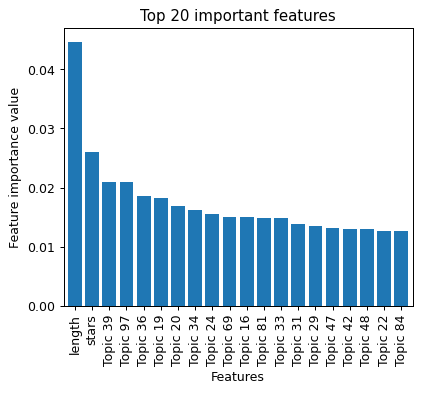

In [45]:
# Plot feature importances 
fig, axs = plt.subplots(dpi=90, figsize = (5, 4))
feature_importances.head(20).plot(kind='bar',
    width = 0.8,
    ax = axs,
    )
axs.set_xlabel('Features')
axs.set_ylabel('Feature importance value')
axs.set_title('Top 20 important features')

In [74]:
headers = np.argsort(feature_importances)[::-1][0:20]
np.std(headers)
print(headers)

Topic 83     0
Topic 2      1
Topic 13     2
Topic 59     3
Topic 78     4
Topic 58     5
Topic 26     6
Topic 86     7
Topic 23     8
Topic 11     9
Topic 67    10
Topic 10    11
Topic 18    12
Topic 91    13
Topic 74    14
Topic 15    15
Topic 88    16
Topic 64    17
Topic 1     18
Topic 37    19
dtype: int64


C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:44: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial, where)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:40: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial, where)


(0.0, 0.08)

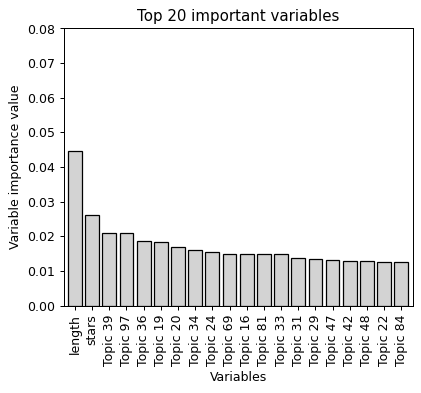

In [75]:
# Plot feature importances with error 
fig, axs = plt.subplots(dpi=90, figsize = (5, 4))
feature_importances.head(20).plot(kind='bar',
    width = 0.8,
    ax = axs,
    color = 'lightgrey',
    edgecolor = 'black',
    yerr=headers
    )
axs.set_xlabel('Variables')
axs.set_ylabel('Variable importance value')
axs.set_title('Top 20 important variables')
plt.ylim((0,0.08))

In [76]:
# Extract accuracy metric value
y_pred = rf_model.predict(X_test)
print("Accuracy:", metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.6661191548039096


Text(0.5, 1.0, 'Receiver Operating Characteristic')

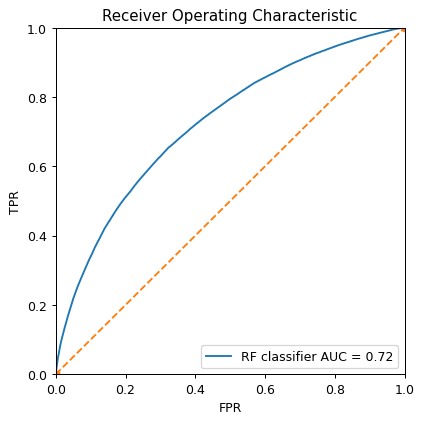

In [78]:
# Plot ROC curve
fig, axs = plt.subplots(dpi=90, figsize = (5,5))
probs = rf_model.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test, probs)
scores = metrics.roc_auc_score(y_test, probs)
plt.plot(fpr,tpr,label="RF classifier AUC = "+str(round(scores,2)))
plt.plot([0,1],[0,1], '--h')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.0])
plt.legend(loc='lower right')
plt.ylabel('TPR')
plt.xlabel('FPR')
plt.title('Receiver Operating Characteristic')

In [79]:
# Save RF model 
joblib.dump(rf_model, "rf_model.joblib")

['rf_model.joblib']

In [80]:
# Data sampling on random
sample_n = 10000
X_test_prob = X_test.copy()
X_test_prob['prob'] = probs
data = X_test_prob.sample(n=sample_n, random_state=1)

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y, data. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, '10000 data samples (probability~feature)')

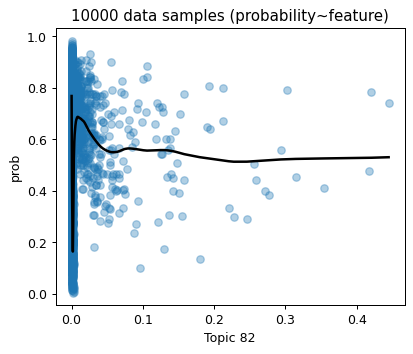

In [81]:
# Scatterplot for topic 82
fig, axs = plt.subplots(dpi=90, figsize=(5, 4))
sns.regplot('Topic 82', 'prob', data, lowess=True, scatter_kws={'alpha':0.35}, line_kws={'lw':2, 'color': 'black'}, ax=axs)
plt.title("10000 data samples (probability~feature)")

Text(0.5, 1.0, '10000 data samples (probability~feature)')

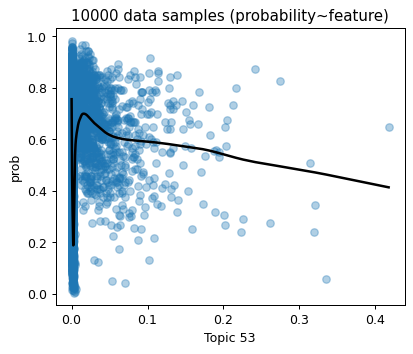

In [82]:
# Scatterplot for topic 53
fig, axs = plt.subplots(dpi=90, figsize=(5, 4))
sns.regplot('Topic 53', 'prob', data, lowess=True, scatter_kws={'alpha':0.35}, line_kws={'lw':2, 'color': 'black'}, ax=axs)
plt.title("10000 data samples (probability~feature)")

Text(0.5, 1.0, '10000 data samples (probability~feature)')

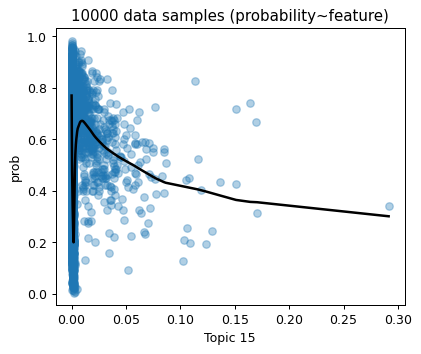

In [83]:
# Scatterplot for topic 15
fig, axs = plt.subplots(dpi=90, figsize=(5, 4))
sns.regplot('Topic 15', 'prob', data, lowess=True, scatter_kws={'alpha':0.35}, line_kws={'lw':2, 'color': 'black'}, ax=axs)
plt.title("10000 data samples (probability~feature)")